In [109]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC


In [110]:
# Load in the train and test datasets
train = pd.read_csv('/Users/ness001/ds/【datas】/titanic/train.csv')
test = pd.read_csv('/Users/ness001/ds/【datas】/titanic/test.csv')

In [111]:
PassengerId = test['PassengerId']

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [113]:
full_data = [train, test]#方便使用for语句对train和test一并操作

In [114]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [115]:
train.Cabin.dtypes

dtype('O')

# Feature Exploration, Engineering and Cleaning

In [116]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [117]:
print (train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [118]:
for dataset in full_data:
    dataset['FamilySiz']=dataset['SibSp']+dataset['Parch']+1 

In [119]:
train[['FamilySiz','Survived']].groupby(['FamilySiz']).mean()

,Survived
FamilySiz,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


In [120]:
a=train[['FamilySiz','Survived']].groupby(['FamilySiz']).mean()

In [121]:
#dataset只是一个中间的替身变量，因为最后一个循环中储存了test，所以是test的值在里面；原来的两个数据集已经变了

In [122]:
test.head(3 )

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySiz
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1


In [123]:
train.head(3 )

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySiz
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


In [124]:
test.shape

(418, 12)

## cabin

In [125]:
train['has_cabin']=train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
###

In [126]:
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


In [129]:
# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySiz'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [130]:
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
    
    #按照分位数将Fare分为四个区间
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [131]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySiz,has_cabin,IsAlone,CategoricalFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,0,"(-0.001, 7.91]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,1,0,"(31.0, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,1,"(7.91, 14.454]"


In [132]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    #填补年龄的关键语句，均值上下标准差
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)#为了生成int区间而不用分位数
# Define funct

In [133]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)#返回第一个正则表达式匹配出来的字串，具体看菜鸟文档
    return ""

In [134]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [135]:
train.head(3 )

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySiz,has_cabin,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,2,0,0,"(-0.001, 7.91]","(16.0, 32.0]",Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2,1,0,"(31.0, 512.329]","(32.0, 48.0]",Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,1,"(7.91, 14.454]","(16.0, 32.0]",Miss


In [136]:
## 对于频率低的类别，划分为一个group的方法，替代掉

In [137]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona',''], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [138]:
## 简单映射，性别

In [139]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [140]:
## 对类别做label映射（不是onehot）

In [141]:
for dataset in full_data:


    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping).astype(int)
    

In [142]:
train.Title.isnull().sum()

0

In [143]:
for dataset in full_data:
     dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    

In [144]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySiz,has_cabin,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,NaN,0,2,0,0,"(-0.001, 7.91]","(16.0, 32.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,1,2,1,0,"(31.0, 512.329]","(32.0, 48.0]",3
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,1,"(7.91, 14.454]","(16.0, 32.0]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,C123,0,2,1,0,"(31.0, 512.329]","(32.0, 48.0]",3
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,NaN,0,1,0,1,"(7.91, 14.454]","(32.0, 48.0]",1


In [145]:
#按照两个分类变量的分位数进行映射group

In [146]:
for dataset in full_data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 

## 手动特征选择

In [147]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [150]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'FamilySiz', 'has_cabin', 'IsAlone', 'Title'],
      dtype='object')

## 统计角度的探索

In [151]:
%matplotlib inline

In [ ]:
# pearson

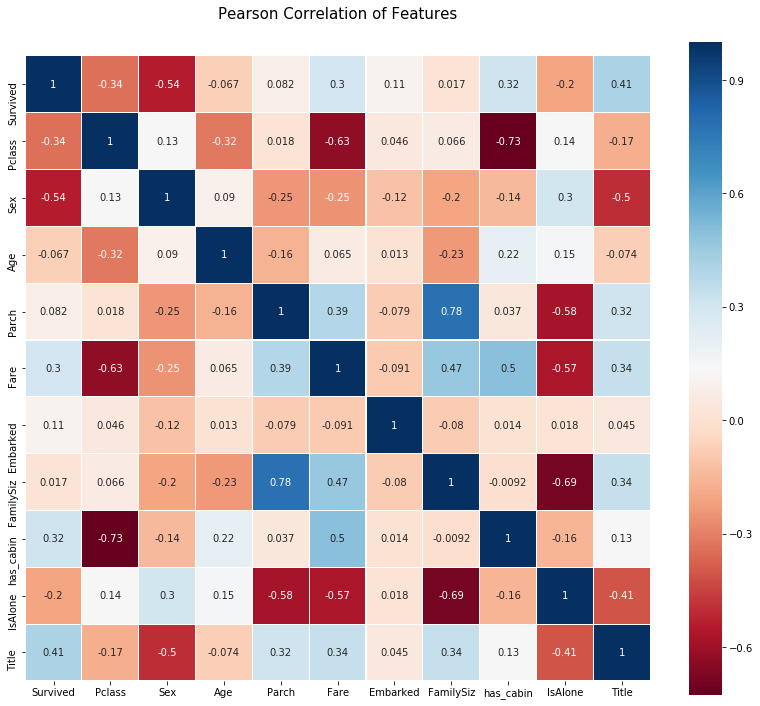

In [157]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)#what is y and size here?
#experiment  y is the distance between title and the map,size is just font size
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [158]:
#从协方差矩阵中可以看出变量之间相关性不是很强，说明冗余信息较少，只有家庭大小和parch相关性较强

In [ ]:
#从散点图矩阵中可以看到两两变量之间的相关性

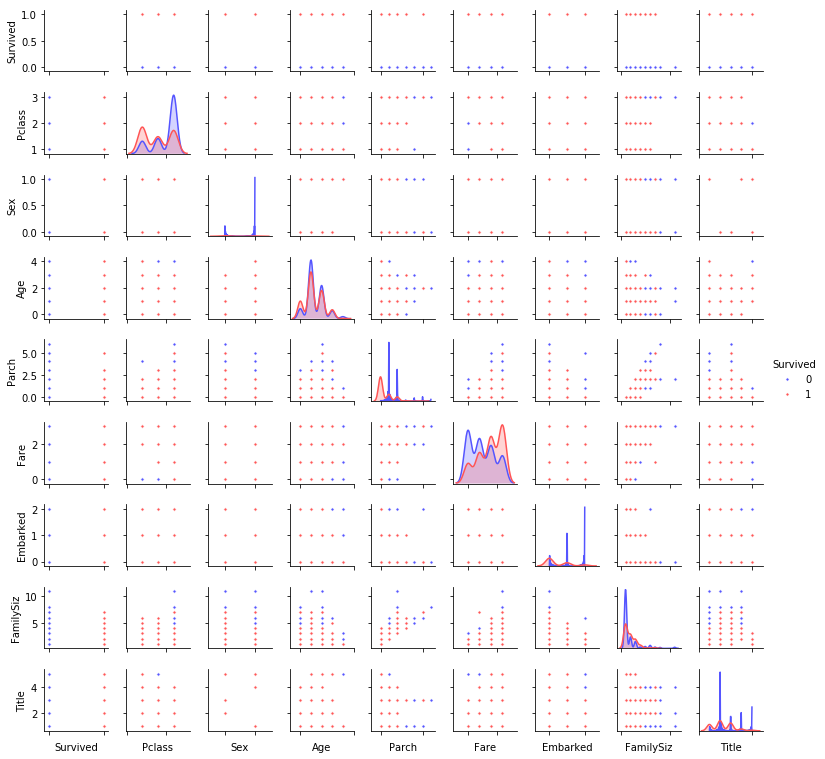

In [160]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySiz', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])#hue是类型

# 建模减少重复劳动的方法

学会使用类啊！！！

In [166]:
from sklearn.model_selection import KFold
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [170]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [167]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    } 

In [168]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [169]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [171]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

TypeError: 'KFold' object is not iterable